# <h1 style='background:#FFFF00; border:2; border-radius: 10px; font-size:250%; font-weight: bold; color:black'><center>Daily Climate time series data</center></h1>

<img src = "https://i.gifer.com/embedded/download/8yhV.gif" width = 900 height = 300/>


<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
    
<h1 style='background:#FFFF00; border:0; border-radius: 10px; color:black'><center> Table of contents. </center></h1>

### [**1. Importing Libraries and Loading Data**](#title-one)

### [**2. Brief information about the data**](#title-two)

### [**3. Exploratory Data Analysis and statistical tests**](#title-three)
    
### [**4. Forecasting**](#title-four)

### [**4. A word about global warming**](#title-four)    


    
<a id="title-one"></a>
<h1 style='background:#FFFF00; border:2; border-radius: 10px; color:black'><center>Importing Libraries and Loading Data</center></h1>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import iplot, init_notebook_mode
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import datetime as dt

In [ ]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet,Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
import xgboost as xgb

In [ ]:
import io
train = pd.read_csv('DailyDelhiClimateTrain.csv')

<a id="title-two"></a>
<h1 style='background:#FFFF00; border:2; border-radius: 10px; color:black'><center>Brief information about the data</center></h1>

In [ ]:
train

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


data are presented by 5 signs for 1462 days.
What signs do we have?
* date - date
* meantemp - Mean temperature averaged out from multiple 3 hour intervals in a day.
* humidity - Humidity value for the day (units are grams of water vapor per cubic meter volume of air).
* wind_speed - Wind speed measured in kmph.
* Pressure reading of weather (measure in atm).

In [ ]:
train.describe().style.background_gradient(cmap = 'Oranges')

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


There are outliers both in terms of minimum and maximum values in all features.
There is a question with atmospheric pressure. In what units is it represented and how is it measured?

Let's look at the data type.

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


Great, you need to work with the date sign.

<a id="title-three"></a>
<h1 style='background:#FFFF00; border:2; border-radius: 10px; color:black'><center>Exploratory Data Analysis and statistical tests</center></h1>

Let's check our dataset for information gaps

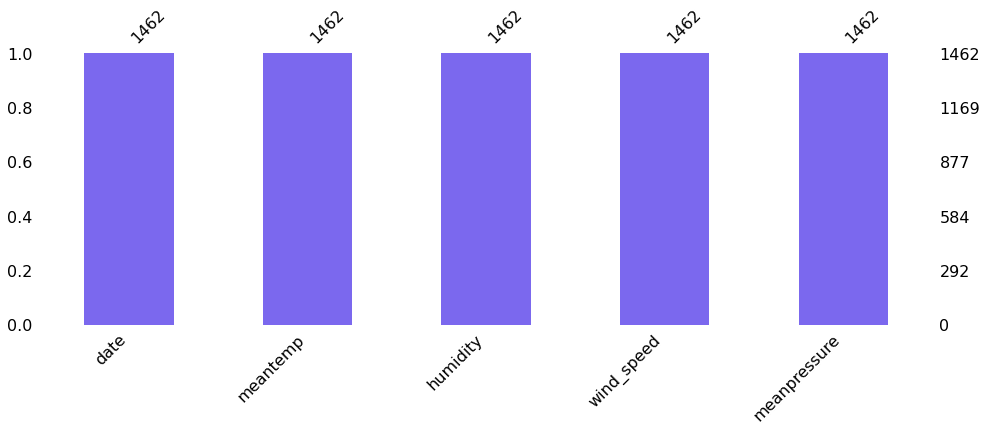

In [ ]:
msno.bar(train, figsize = (16,5),color = "#7B68EE")
plt.show()

There are no gaps in the data.

Visualize the change in temperature depending on the date

In [ ]:
fig = px.line(train, x='date', y='meantemp', title="Temperature change",template='plotly_dark')

fig.show()

The graph shows the seasonality of temperature changes. This will help predict the temperature value for the whole year :)

In [ ]:
fig = px.line(train, x='date', y='humidity', title="Humidity change",template='plotly_dark')

fig.show()

There is also seasonality.

In [ ]:
fig = px.line(train, x='date', y='wind_speed', title="Change in wind speed",template='plotly_dark')

fig.show()

In [ ]:
fig = px.line(train, x='date', y='meanpressure', title="Temperature change",template='plotly_dark')

fig.show()

Hypothesis: this feature has no correlation with the rest.

Let us decompose the temperature value into seasonality, trend and residual components.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
ts_decomposition = seasonal_decompose(x=train['meantemp'], model='additive', period=6)
trend_estimate = ts_decomposition.trend
seasonal_estimate = ts_decomposition.seasonal
residual_estimate = ts_decomposition.resid

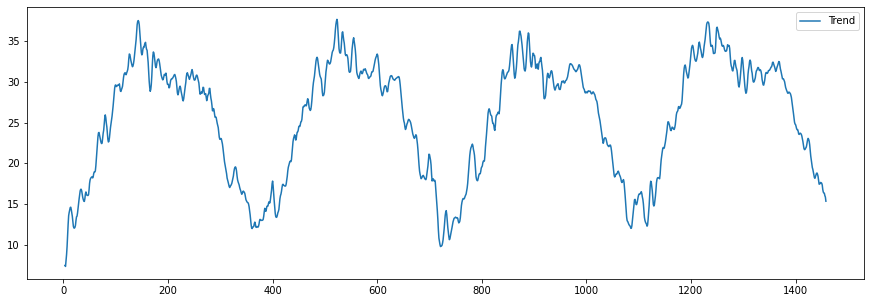

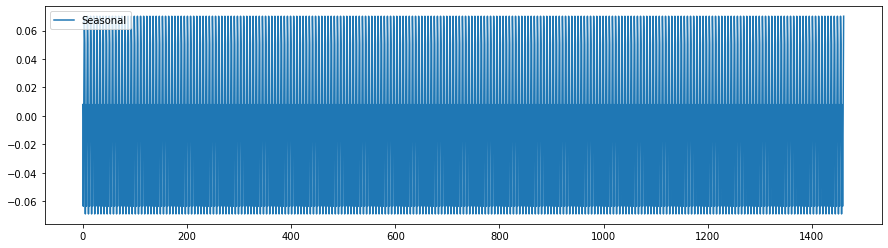

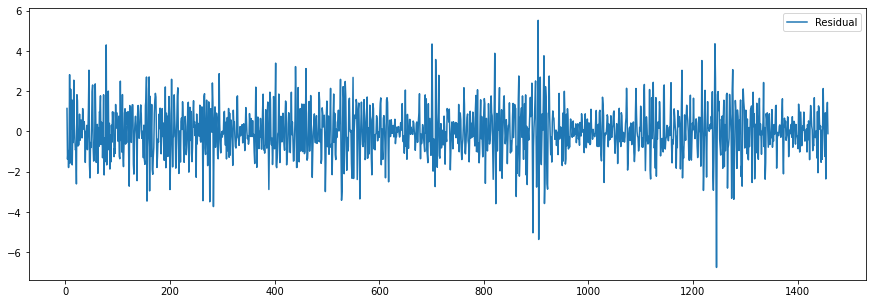

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(trend_estimate, label='Trend')
plt.legend()

plt.figure(figsize=(15,4))
plt.plot(seasonal_estimate, label='Seasonal')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(residual_estimate, label='Residual')
plt.legend()

There are large residuals in the data.

In [ ]:
train['date'] = pd.to_datetime(train['date'], format = '%Y-%m-%d')

In [ ]:
train['Day_of_Week'] = train['date'].dt.dayofweek
train['YEAR']=train['date'].dt.year
train['DAY']=train['date'].dt.day
train['MONTH']=train['date'].dt.month

In [ ]:
train.columns

Index(['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure',
       'Day_of_Week', 'YEAR', 'DAY', 'MONTH'],
      dtype='object')

Let's analyze our features.

In [ ]:
numeric_features=['meantemp', 'humidity', 'wind_speed', 'meanpressure']

In [ ]:
fig = make_subplots(rows=len(numeric_features), cols=3)
i=1
for feature in numeric_features:
  fig.add_trace(go.Histogram(x=train[feature], name=feature), row=i, col=1)
  fig.add_trace(go.Box(x=train[feature], name=feature), row=i, col=2)
  fig.add_trace(go.Violin(x=train[feature], name=feature), row=i, col=3)
  i+=1
fig.update_layout(height=1800, width=1200, title_text='<b>Continuos distributions', title_x=0.5)
fig.show()

* There are minor outliers for all two features. One feature is outliers both in terms of the maximum and minimum values.
* Features are not normally distributed, with the exception of humidity and possibly atmospheric pressure.

I'm interested in the target sign - the average temperature. Let's build a histogram of the distribution of unit differences for this feature.

In [ ]:
tempdiff=train['meantemp'].diff(periods=1).dropna()

In [ ]:
fig = go.Figure(data=[go.Histogram(x=tempdiff,histnorm='probability density')])
fig.update_layout(
    title="Histogram of unit differences of mean temperature",
    title_x = 0.5,
    xaxis_title="Unit difference",
    yaxis_title="Probability Density",
    legend=dict(x=.5, xanchor="center", orientation="h"),
    margin=dict(l=0, r=0, t=30, b=0))
fig.show()

Hypothesis: a series of unit differences is stationary and further work with it is possible.

Let's build scatterplots of our feature with other features in the table.

In [ ]:
for feature in numeric_features:
  fig = px.scatter(train, x='meantemp',y=feature)
  fig.update_layout(title=f"meantemp with {feature}")
  fig.show()

There is a slight inverse correlation with the sign of humidity.

Now you need to check the unit difference in temperature with the value of humidity.

In [ ]:
fig = px.scatter(x=tempdiff,y=train.humidity[1:])
fig.update_layout(title="tempdiff with humidity")
fig.show()

The graph below shows that it is not possible to predict the temperature value from the previous day's humidity value.

Let's look at sliding windows using exponential smoothing.

In [ ]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

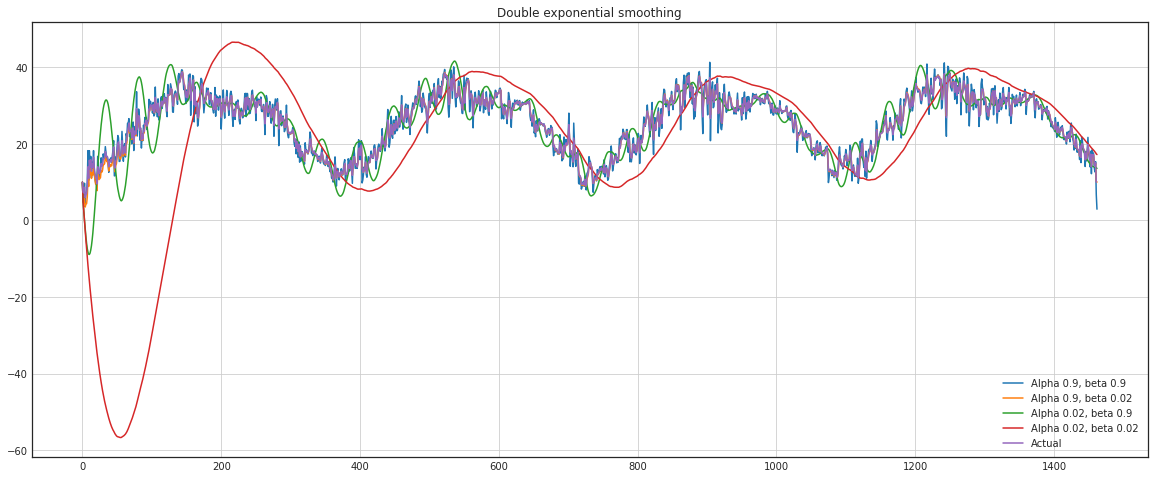

In [ ]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(double_exponential_smoothing(train.meantemp, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(train.meantemp.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double exponential smoothing")
    plt.grid(True)

Let's analyze by dates.

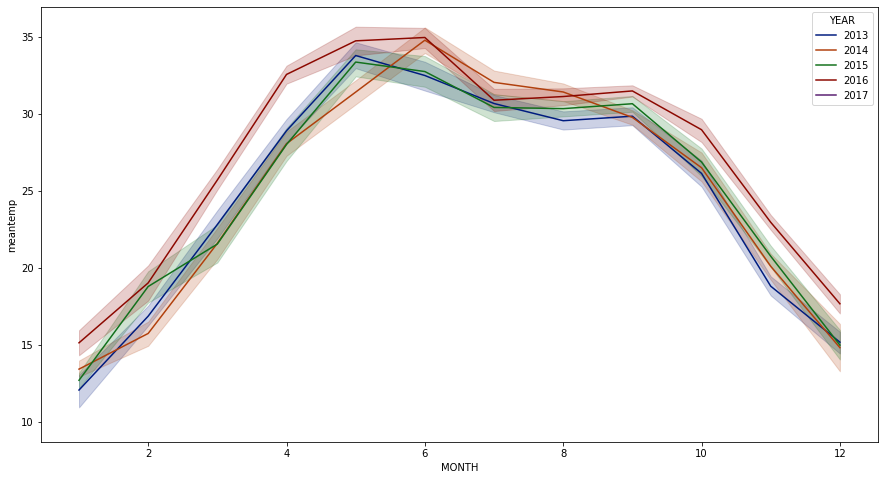

In [ ]:
plt.figure(figsize=(15,8))
sns.lineplot(data=train,x='MONTH',y='meantemp',hue='YEAR',palette='dark')

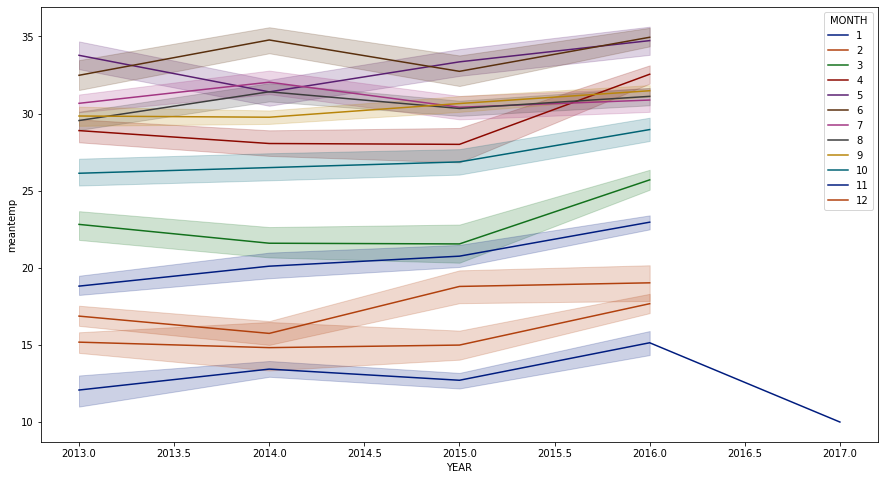

In [ ]:
plt.figure(figsize=(15,8))
sns.lineplot(data=train,x='YEAR',y='meantemp',hue='MONTH',palette='dark')

As we can see, the average temperature increases from year to year. This is primarily due to global climate change.

Let's run statistical tests with our dataset. it is proposed to start with the construction of a correlation matrix.

In [ ]:
correlation = train.corr()
print(correlation['meantemp'].sort_values(ascending = False),'\n')

meantemp        1.000000
wind_speed      0.306468
MONTH           0.122667
YEAR            0.103803
DAY             0.006475
Day_of_Week    -0.009941
meanpressure   -0.038818
humidity       -0.571951
Name: meantemp, dtype: float64 



Index(['meantemp', 'wind_speed', 'MONTH', 'YEAR', 'DAY', 'Day_of_Week',
       'meanpressure', 'humidity'],
      dtype='object')


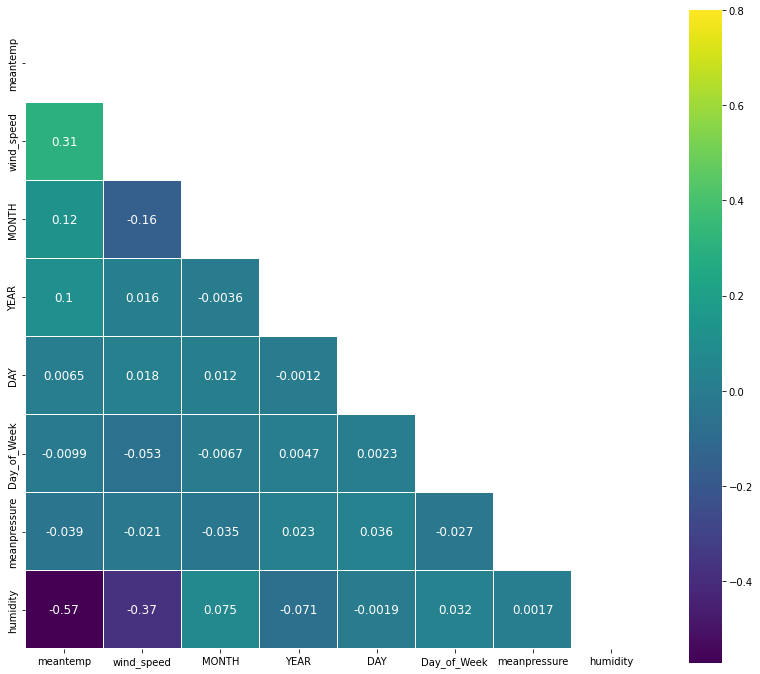

In [ ]:
k= 10
cols = correlation.nlargest(k,'meantemp')['meantemp'].index
print(cols)
cm = np.corrcoef(train[cols].values.T)
mask = np.triu(np.ones_like(train.corr()))
f , ax = plt.subplots(figsize = (14,12))
sns.heatmap(cm,mask=mask, vmax=.8, linewidths=0.01,square=True,annot=True,cmap='viridis',
            linecolor="white",xticklabels = cols.values ,annot_kws = {'size':12},yticklabels = cols.values)

* There is a slight inverse correlation with humidity.

Let's check if there is statistical significance between year, month, day and average temperature.

In [ ]:
train.columns

Index(['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure',
       'Day_of_Week', 'YEAR', 'DAY', 'MONTH'],
      dtype='object')

In [ ]:
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(train['Day_of_Week'], train['meantemp'])
print('Mann-Whitney test=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
		print('You cant reject the null hypothesis')
else:
		print('Rejecting the null hypothesis')

Mann-Whitney test=104.500, p=0.000
Rejecting the null hypothesis


In [ ]:
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(train['YEAR'], train['meantemp'])
print('Mann-Whitney test=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
		print('You cant reject the null hypothesis')
else:
		print('Rejecting the null hypothesis')

Mann-Whitney test=2137444.000, p=0.000
Rejecting the null hypothesis


In [ ]:
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(train['DAY'], train['meantemp'])
print('Mann-Whitney test=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
		print('You cant reject the null hypothesis')
else:
		print('Rejecting the null hypothesis')

Mann-Whitney test=431684.000, p=0.000
Rejecting the null hypothesis


In [ ]:
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(train['MONTH'], train['meantemp'])
print('Mann-Whitney test=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
		print('You cant reject the null hypothesis')
else:
		print('Rejecting the null hypothesis')

Mann-Whitney test=13072.000, p=0.000
Rejecting the null hypothesis


There is statistical significance in the data.

Let's check our target feature for stationarity.

Dickey-Fuller criterion: p=0.277412


/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



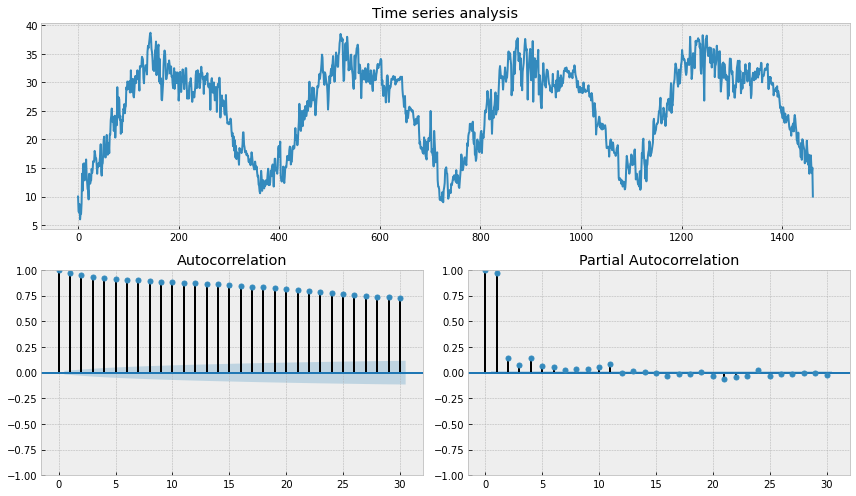

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time series analysis')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Dickey-Fuller criterion: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return

tsplot(train.meantemp, lags=30)

The series is non-stationary.

Let us check a number of unit differences for stationarity.

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



Dickey-Fuller criterion: p=0.000000


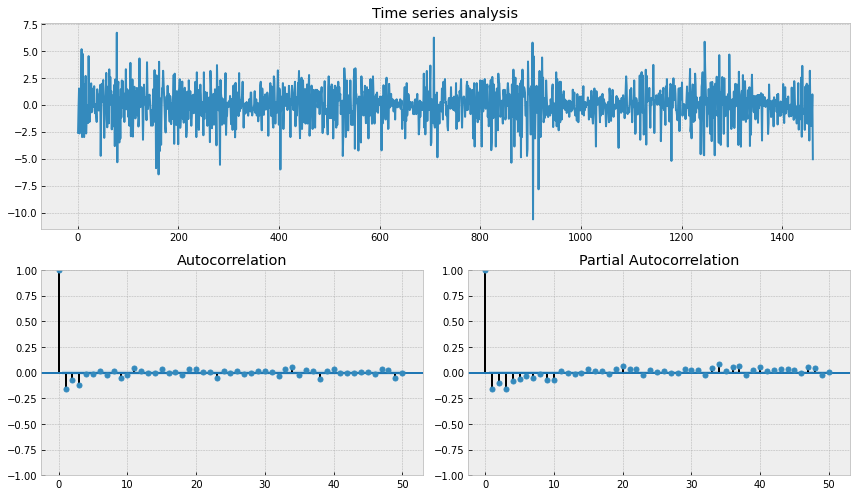

In [ ]:
tsplot(tempdiff, lags=50)

The Dickey-Fuller test is equal to zero, but it has a high variance in the form of the graph.

<a id="title-four"></a>
<h1 style='background:#FFFF00; border:2; border-radius: 10px; color:black'><center>Forecasting</center></h1>

Let's forecast the initial series using the ARIMA model for a period of 30 days. I borrowed this code from RABI KUMAR SINGH. Thanks a lot! With an error MAPE> 5 percent, I propose to work with single residuals.

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pmdarima as pm
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
train = pd.read_csv('DailyDelhiClimateTrain.csv')

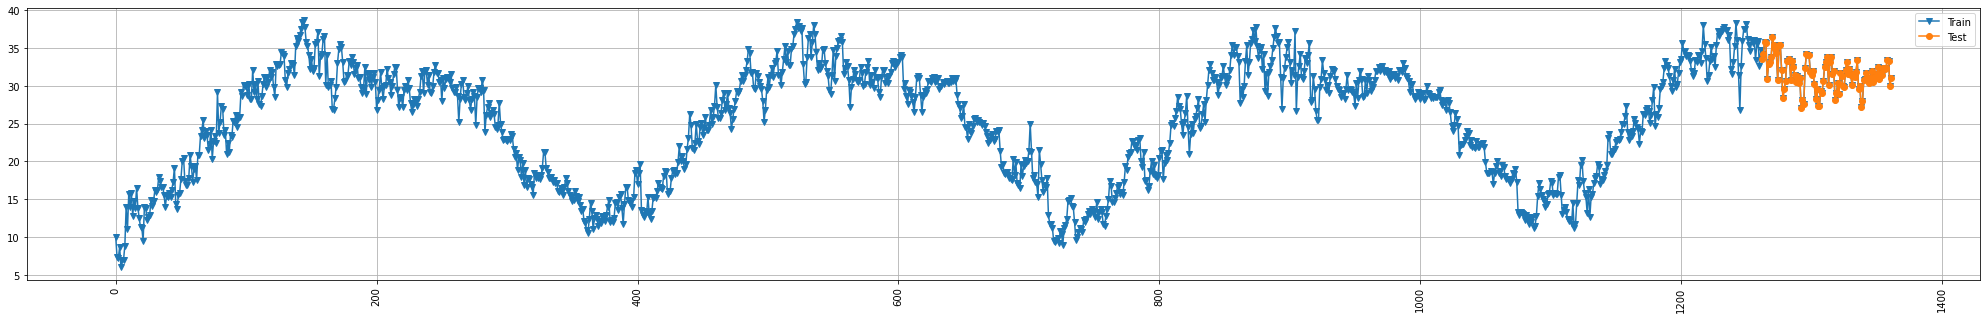

In [ ]:
train=train[:-100]
test=train[-100:]

plt.figure(figsize=(35,5))
plt.grid()
plt.plot(train['meantemp'], marker='v', label='Train')
plt.plot( test['meantemp'], marker='o', label='Test')
plt.xticks(rotation=90)
plt.legend()
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4]             : AIC=inf, Time=12.52 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=5457.135, Time=0.54 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=5182.315, Time=0.96 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=inf, Time=4.31 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=5181.505, Time=0.27 sec
 ARIMA(1,2,0)(0,0,1)[4]             : AIC=5182.246, Time=2.35 sec
 ARIMA(1,2,0)(1,0,1)[4]             : AIC=5184.182, Time=3.54 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=5065.073, Time=1.05 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=5067.061, Time=1.35 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=5067.040, Time=1.85 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=5068.947, Time=2.31 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=4918.194, Time=0.68 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=4777.544, Time=4.50 sec
 ARIMA(3,2,0)(2,0,0)[4]             : AIC=4690.470, Time=7.87 sec
 ARIMA(3,2,0)(2,0,1)[4]             : AIC=

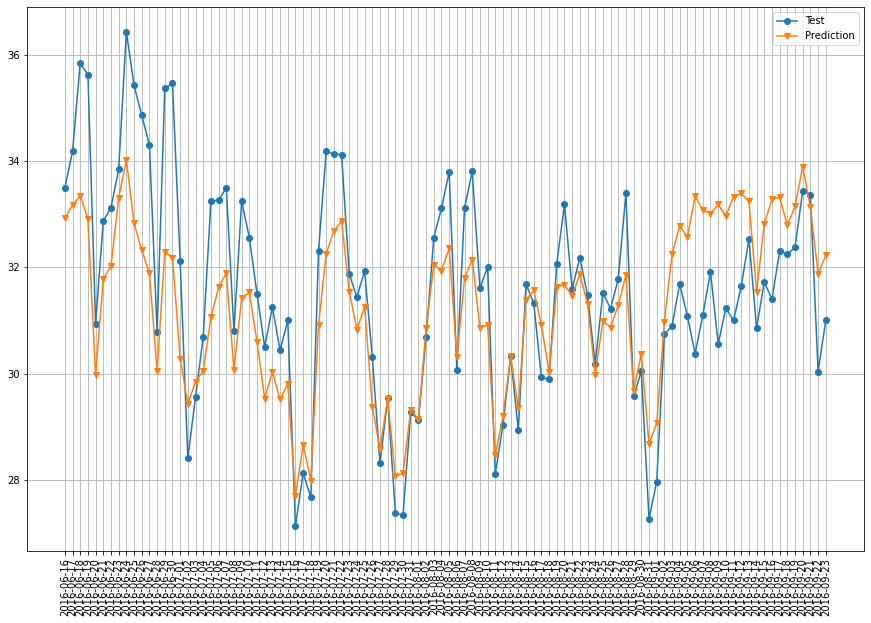

Mean Absolute Percentage Error 0.03292514659330162
Mean Squared Error 1.7392794773153795
RMSE 1.3188174541290312
AIC values 4690.469648290568


In [ ]:
# Model Evaluation

# Fit a simple auto_arima model
arima = pm.auto_arima(train['meantemp'],X=train.drop(columns=['date','meantemp']), d=2,error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=500,m=4,stationary=False,test='adf')

# Print out summary information on the fit
print(arima.summary())
print(arima.params)



pred=arima.predict(n_periods=100, X=test.drop(columns=['date','meantemp']), alpha=0.05)
pred

plt.figure(figsize=(15,10))
plt.grid()
#plt.plot(data['Period'][:-10], train['GDP_GROWTH'], marker='o', label='Train')
plt.plot(train['date'][-100:],test['meantemp'], marker='o', label='Test')
plt.plot(train['date'][-100:],pred, marker='v', label='Prediction')
plt.legend()
plt.xticks(rotation=90)
plt.show()
print("="*50)
print("="*50)
mape=mean_absolute_percentage_error(test['meantemp'], pred)
print("Mean Absolute Percentage Error", mape)
print("="*50)
mse=mean_squared_error(test['meantemp'], pred)
print("Mean Squared Error",mse)
print("="*50)
print("RMSE", (mse)**0.5)
print("="*50)
print("AIC values {}".format(arima.aic()))


Okay, prediction done.

<a id="title-five"></a>
<h1 style='background:#FFFF00; border:2; border-radius: 10px; color:black'><center>A word about global warming</center></h1>

Global warming is a long-term increase in the average temperature of the Earth's climate system, which has been occurring for more than a century, the main cause of which is human activity (anthropogenic factor).


Rise in Earth's surface temperature since the end of the 19th century
Since 1850, on a ten-year scale, the air temperature in each decade has been higher than in any previous decade. Since 1750–1800, humans have been responsible for a 0.8–1.2 °C rise in global average temperature. The probable value of further temperature increase during the 21st century, based on climate models, is 0.3–1.7 °C for the minimum greenhouse gas emission scenario, and 2.6–4.8 °C for the maximum emission scenario.

The effects of global warming include rising sea levels, regional changes in precipitation, more frequent extreme weather events such as heatwaves, and expanding deserts. As stated on the UN website: there is alarming evidence that thresholds have already been exceeded leading to irreversible changes in the ecosystems and climate system of our planet.

One of the most visible processes associated with global warming is the melting of glaciers.

Over the past half century, temperatures in southwest Antarctica, on the Antarctic Peninsula, have risen by 2.5°C. In 2002, a 3,250 km2 iceberg broke away from the 48,000 km² Larsen Ice Shelf on the Antarctic Peninsula. The entire destruction process took only 35 days. The melting of the ice shelf led to the release of a large number of icebergs (over a thousand) into the Weddell Sea. Since the 50s of the 20th century, the area of ​​​​the glacier has decreased by a third. And on July 10-12, 2017, an iceberg broke off from the glacier again, this time with an area of ​​​​about 6,000 km² and a mass of about 1 trillion tons.